### Imports

In [122]:
from cleantext import clean
import re
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import time
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from collections import Counter



[nltk_data] Downloading package punkt to /Users/yaan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/yaan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Task 1

### Clean data

In [138]:
def clean_with_cleantext(text):
    cleaned_text = clean(text,
                         lower=True,
                         no_urls=True,
                         no_emails=True,
                         no_numbers=True,
                         no_digits=True,
                         replace_with_url="",
                         replace_with_email="",
                         replace_with_number="",
                         replace_with_digit="",
                         lang="en")
    cleaned_text = re.sub(r'[-\/]', ' ', cleaned_text)
    cleaned_text = re.sub(r'[!\+\/@#$%^&?!=\<\>_*.,€:;\[\]\{\}\'\"\´\¨\(\)\\]', '', cleaned_text)
    return cleaned_text

def tokenize(text):
    return word_tokenize(text.lower())

def remove_stop_words(tokens):
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token not in stop_words]

def stem(tokens):
    porter = nltk.PorterStemmer()
    return [porter.stem(token) for token in tokens]

def process_text_pipeline(text):
    cleaned_text = clean_with_cleantext(text)
    tokens = tokenize(cleaned_text)
    tokens_no_stop = remove_stop_words(tokens)
    stemmed_tokens = stem(tokens_no_stop)
    return stemmed_tokens

def calculate_unique_sets(news_sample):
    sets = {'before': set(), 'after_cleaning': set(), 'after_tokenization': set(), 
            'after_stop_word_removal': set(), 'after_stemming': set()}
    
    for content in news_sample['content']:
        if isinstance(content, str):
            sets['before'].update(content.split(' '))
            cleaned_content = clean_with_cleantext(content)
            sets['after_cleaning'].update(cleaned_content.split(' '))
            tokenized_content = tokenize(cleaned_content)
            sets['after_tokenization'].update(tokenized_content)
            no_stop_content = remove_stop_words(tokenized_content)
            sets['after_stop_word_removal'].update(no_stop_content)
            stemmed_content = stem(no_stop_content)
            sets['after_stemming'].update(stemmed_content)
    
    return sets

def plot_unique_word_distribution(sets):
    stages = ['before', 'after_cleaning', 'after_tokenization', 'after_stop_word_removal', 'after_stemming']
    lengths = [len(sets[stage]) for stage in stages]
    
    plt.figure(figsize=(12, 6))
    plt.bar(stages, lengths)
    plt.xlabel('Processing Stage')
    plt.ylabel('Number of Unique Words')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def perform_complete_cleaning(url):
    start_time = time.time()
    news_sample = pd.read_csv(url, low_memory=False, on_bad_lines='skip')
    news_sample['content'] = news_sample['content'].apply(lambda x: ' '.join(process_text_pipeline(x)) if isinstance(x, str) else x)
    end_time = time.time()
    print(f"Completed the cleaning process in {end_time - start_time:.2f} seconds.")
    return news_sample

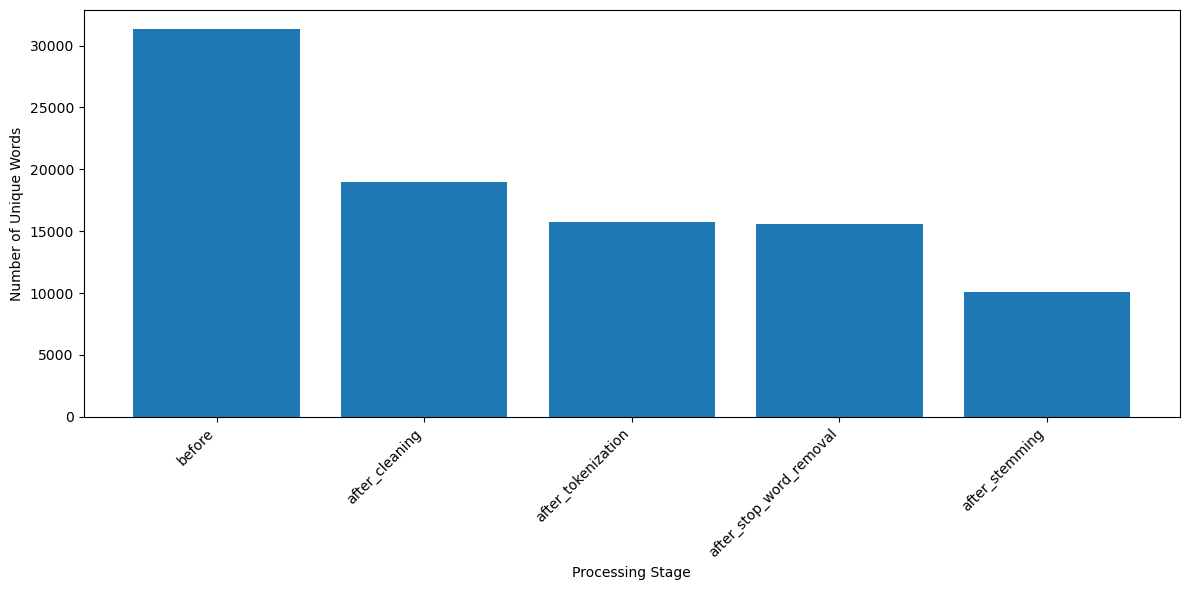

Completed the cleaning process in 1.83 seconds.


In [139]:
url = 'https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv'
news_sample = pd.read_csv(url)
sets = calculate_unique_sets(news_sample)
plot_unique_word_distribution(sets)
cleaned_data = perform_complete_cleaning(url)

## Task 2

### Save cleaned data (WARNING: this will take quite a while)

In [90]:
url = '995,000_rows.csv'
df = perform_complete_cleaning(url)
df.to_csv("cleaned.csv", index=False)

Completed the cleaning process in 4395.68 seconds.


In [113]:
url = 'scraped_articles_comma.csv'
df = perform_complete_cleaning(url)
df.to_csv("bbc_cleaned.csv", index=False)

Completed the cleaning process in 20.47 seconds.


### Prepare data

In [91]:
def prepare_data(df):
    included_types = ['political', 'fake', 'satire', 'reliable', 'conspiracy', 'bias', 'junksci', 'unreliable']
    
    df_filtered = df[df['type'].notna() & df['type'].isin(included_types)]
    
    df_filtered = df_filtered[df_filtered['content'].notna() & df_filtered['content'].str.strip().astype(bool)]
    df_filtered = df_filtered[~df_filtered['content'].str.isnumeric().fillna(False)]
    
    reliable_types = ['reliable', 'political']
    
    df_filtered['type'] = df_filtered['type'].apply(lambda x: 1 if x in reliable_types else 0)
    
    return df_filtered

In [92]:
path_original = '995,000_rows.csv'
df_original = pd.read_csv(path_original, low_memory=False, on_bad_lines='skip')
df_original_processed = prepare_data(df_original)

path_cleaned = 'cleaned.csv'
df_cleaned = pd.read_csv(path_cleaned, low_memory=False, on_bad_lines='skip')
df_cleaned_processed = prepare_data(df_cleaned)

### Plot distribution

In [93]:
def plot_type_distribution(df):
    type_counts = df['type'].value_counts().rename({1: 'Reliable', 0: 'Fake'})
    
    fig, ax = plt.subplots()
    type_counts.plot.pie(autopct='%1.1f%%', startangle=90, labels=type_counts.index, ax=ax)
    ax.set_ylabel('')
    ax.set_title('Distribution of Types')
    
    plt.show()

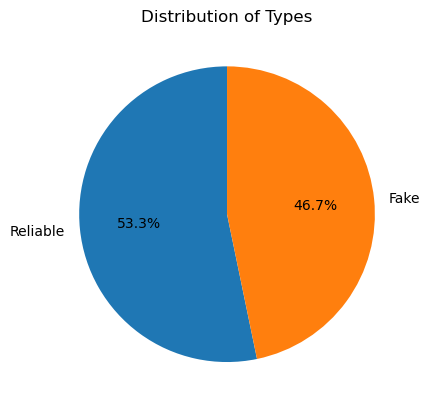

In [132]:
plot_type_distribution(df_original_processed)

### Observation 1 - Biased terms

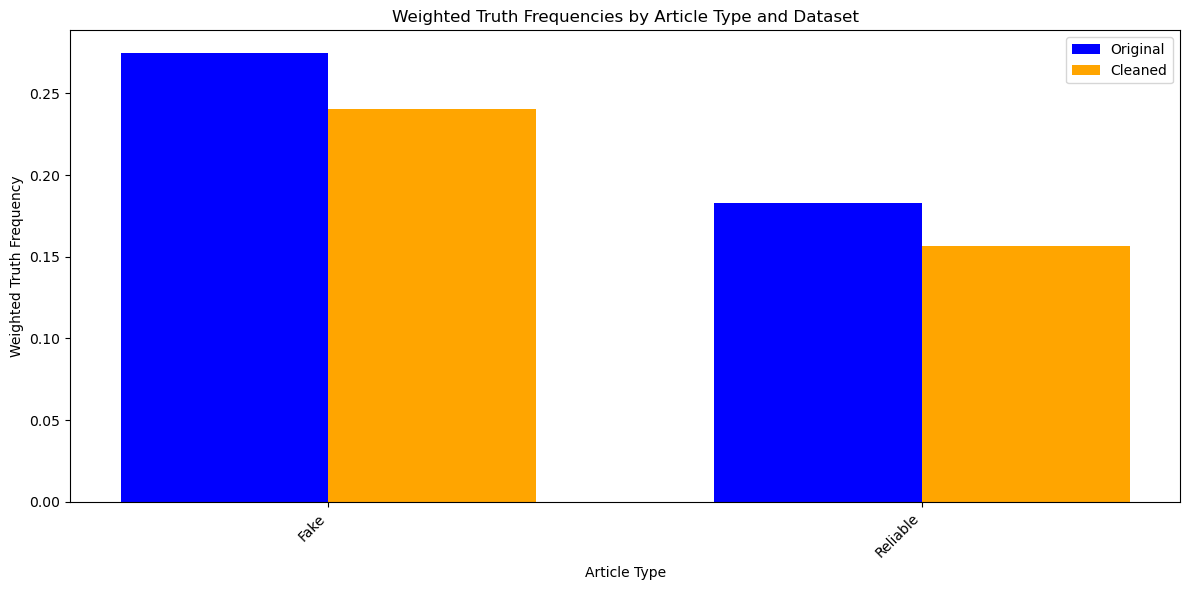

In [133]:
def calculate_weighted_truth_frequencies(df):
    truth_frequencies = {}
    article_counts = {}
    pattern = re.compile(r'\btr(?:ue|uth|uly|uthful|uthfulness)\b', re.IGNORECASE)
    
    for _, row in df.iterrows():
        arttype = row['type']
        content = str(row['content'])
        true_count = len(pattern.findall(content))
        
        if arttype in truth_frequencies:
            truth_frequencies[arttype] += true_count
            article_counts[arttype] += 1
        else:
            truth_frequencies[arttype] = true_count
            article_counts[arttype] = 1
    
    weighted_truth_frequencies = {arttype: truth_frequencies[arttype] / article_counts[arttype] for arttype in truth_frequencies}
    return weighted_truth_frequencies

weighted_truth_freq_original = calculate_weighted_truth_frequencies(df_original_processed)
weighted_truth_freq_cleaned = calculate_weighted_truth_frequencies(df_cleaned_processed)

categories = ['Fake', 'Reliable']

original_freqs = [weighted_truth_freq_original.get(category, 0) for category in [0, 1]]
cleaned_freqs = [weighted_truth_freq_cleaned.get(category, 0) for category in [0, 1]]

x = range(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x, original_freqs, width, label='Original', color='blue')
bars2 = ax.bar([p + width for p in x], cleaned_freqs, width, label='Cleaned', color='orange')

ax.set_xlabel('Article Type')
ax.set_ylabel('Weighted Truth Frequency')
ax.set_title('Weighted Truth Frequencies by Article Type and Dataset')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(categories)
ax.legend()

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Observation 2 - Content length

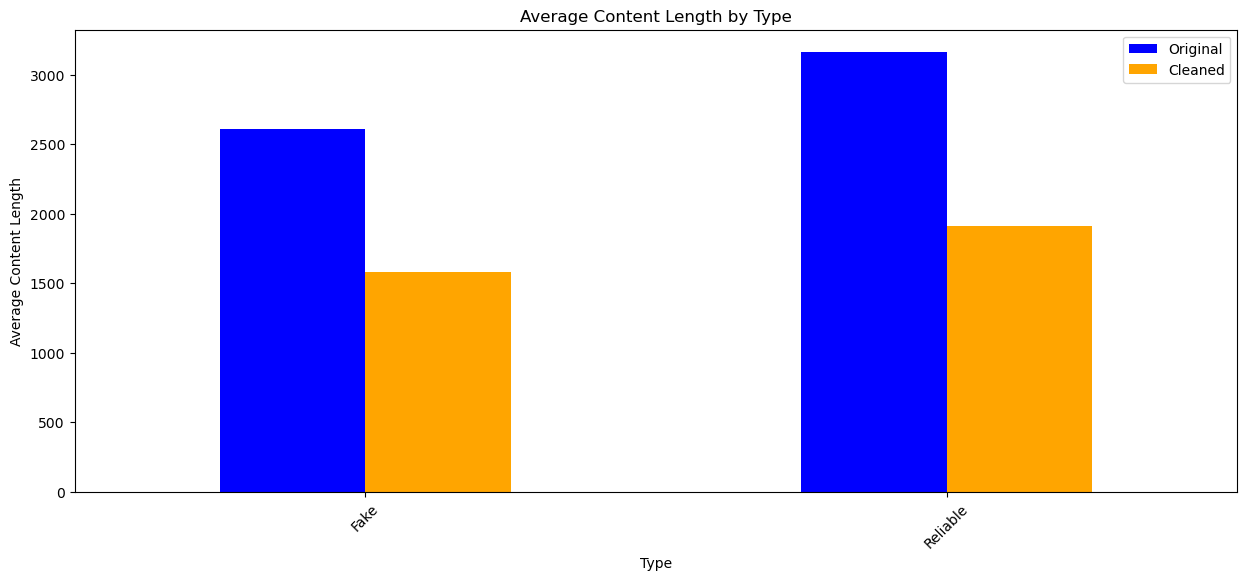

In [134]:
def calculate_avg_content_length_by_type(df):
    df['content_length'] = df['content'].apply(lambda x: len(str(x)))
    
    avg_content_length_by_type = df.groupby('type')['content_length'].mean()
    
    avg_content_length_by_type.index = avg_content_length_by_type.index.map({0: 'Fake', 1: 'Reliable'})
    
    return avg_content_length_by_type

def plot_avg_content_length(avg_content_length_original, avg_content_length_cleaned):
    df_plot = pd.DataFrame({'Original': avg_content_length_original, 'Cleaned': avg_content_length_cleaned})
    
    ax = df_plot.plot(kind='bar', figsize=(15, 6), color=['blue', 'orange'])
    plt.title('Average Content Length by Type')
    plt.xlabel('Type')
    plt.ylabel('Average Content Length')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

avg_content_length_original = calculate_avg_content_length_by_type(df_original_processed)
avg_content_length_cleaned = calculate_avg_content_length_by_type(df_cleaned_processed)

plot_avg_content_length(avg_content_length_original, avg_content_length_cleaned)

### Observation 3 - Average word length

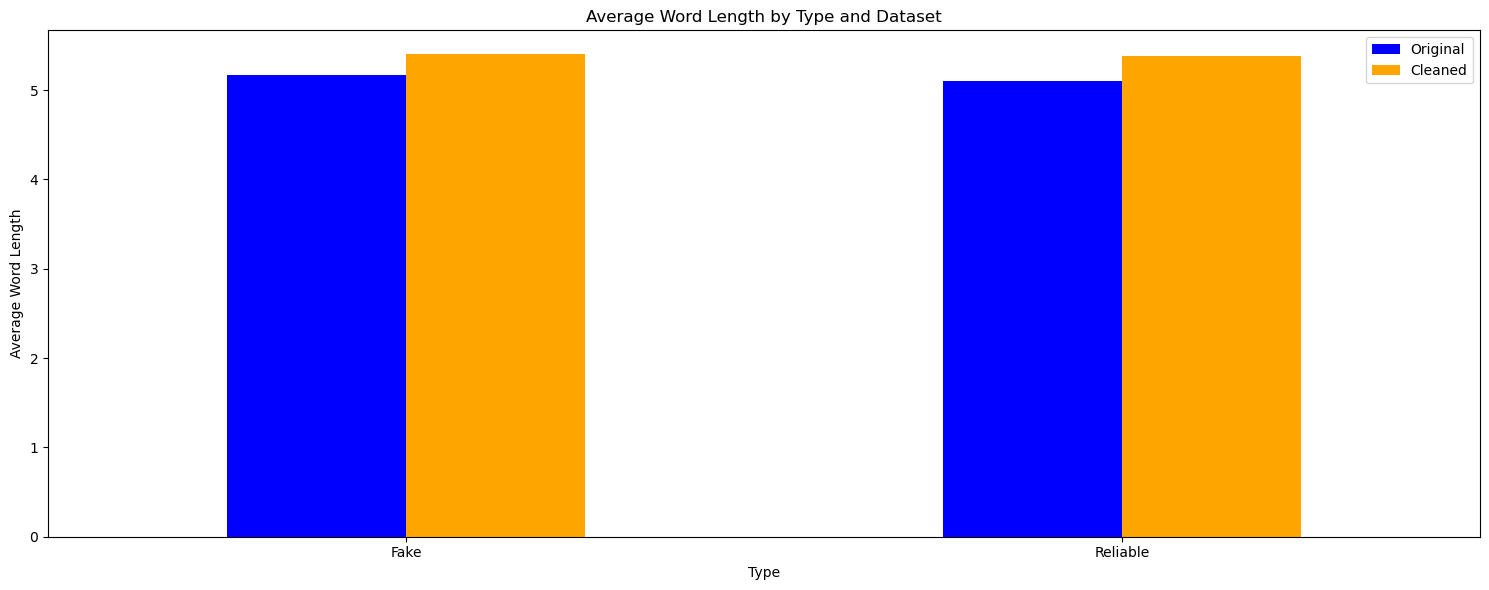

In [135]:
def calculate_avg_word_length_by_type(df):
    df['average_word_length'] = df['content'].apply(lambda x: np.mean([len(word) for word in str(x).split()]) if len(str(x).split()) > 0 else 0)
    
    avg_word_length_by_type = df.groupby('type')['average_word_length'].mean()
    
    avg_word_length_by_type.index = avg_word_length_by_type.index.map({0: 'Fake', 1: 'Reliable'})
    
    return avg_word_length_by_type

def plot_avg_word_length(avg_word_length_original, avg_word_length_cleaned):
    df_plot = pd.DataFrame({'Original': avg_word_length_original, 'Cleaned': avg_word_length_cleaned})
    
    ax = df_plot.plot(kind='bar', figsize=(15, 6), color=['blue', 'orange'])
    plt.title('Average Word Length by Type and Dataset')
    plt.xlabel('Type')
    plt.ylabel('Average Word Length')
    plt.xticks(rotation=0)
    plt.legend()
    plt.tight_layout()
    plt.show()
avg_word_length_original = calculate_avg_word_length_by_type(df_original_processed)
avg_word_length_cleaned = calculate_avg_word_length_by_type(df_cleaned_processed)

plot_avg_word_length(avg_word_length_original, avg_word_length_cleaned)

### Observation 4 - Lix number

Original: {'Fake': 44.06579252598979, 'Reliable': 45.057558220033215}
Cleaned: {'Fake': 0.0, 'Reliable': 0.0}
Original Keys: {'Fake': 44.06579252598979, 'Reliable': 45.057558220033215}
Cleaned Keys: {'Fake': 0.0, 'Reliable': 0.0}


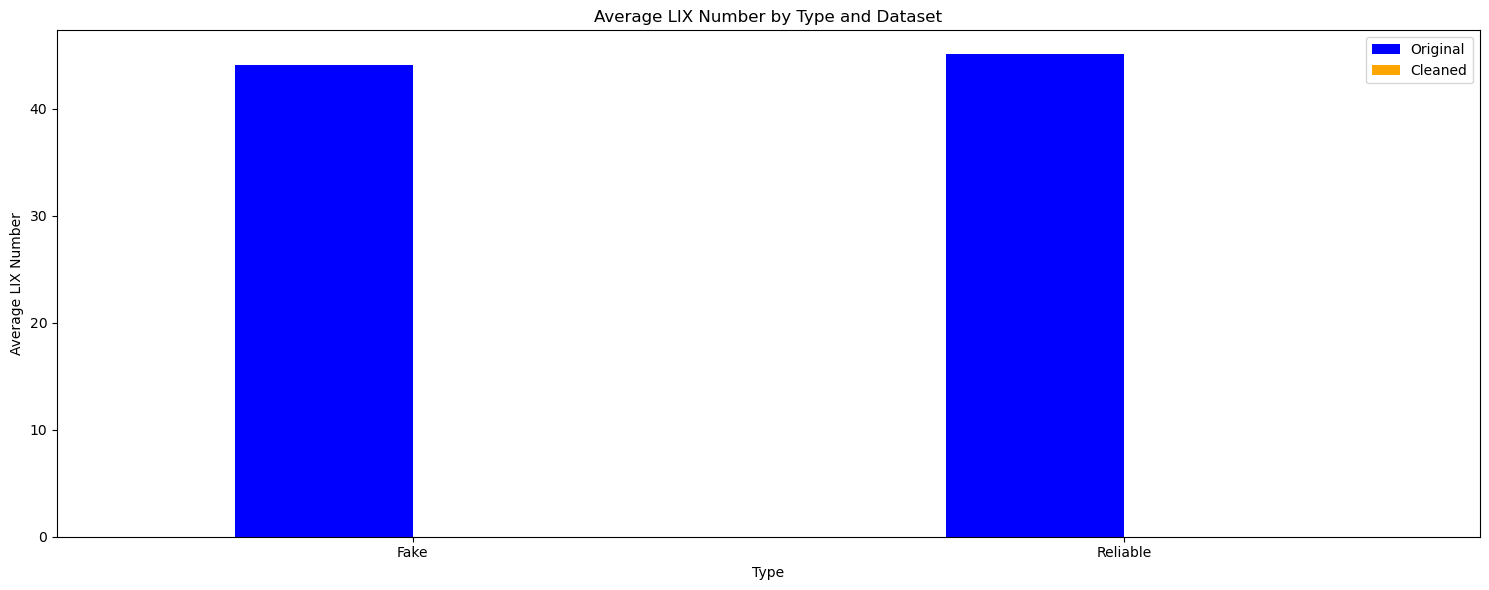

In [121]:
def calculate_lix(text):
    words = text.split()
    num_words = len(words)
    num_sentences = text.count('.') + text.count('?') + text.count('!')
    num_long_words = sum(1 for word in words if len(word) > 6)
    if num_sentences == 0:
        return 0
    lix = (num_words / num_sentences) + (num_long_words / num_words) * 100
    return lix


def calculate_avg_lix_by_type(df):
    df['lix_number'] = df['content'].apply(lambda x: calculate_lix(str(x)))
    avg_lix_number_by_type = df.groupby('type')['lix_number'].mean()
    avg_lix_number_by_type.index = avg_lix_number_by_type.index.map({0: 'Fake', 1: 'Reliable'})
    return avg_lix_number_by_type.to_dict()

def plot_avg_lix_number(avg_lix_number_original, avg_lix_number_cleaned):
    keys = list(set(avg_lix_number_original.keys()).union(set(avg_lix_number_cleaned.keys())))
    print("Original Keys:", avg_lix_number_original)
    print("Cleaned Keys:", avg_lix_number_cleaned)
    
    data = {'Original': [avg_lix_number_original.get(key, np.nan) for key in keys],
            'Cleaned': [avg_lix_number_cleaned.get(key, np.nan) for key in keys]}
    
    df_plot = pd.DataFrame(data, index=keys).sort_index()
    
    ax = df_plot.plot(kind='bar', figsize=(15, 6), color=['blue', 'orange'])
    plt.title('Average LIX Number by Type and Dataset')
    plt.xlabel('Type')
    plt.ylabel('Average LIX Number')
    plt.xticks(rotation=0)
    plt.legend()
    plt.tight_layout()
    plt.show()

print("Original:", calculate_avg_lix_by_type(df_original_processed))
print("Cleaned:", calculate_avg_lix_by_type(df_cleaned_processed))

plot_avg_lix_number(avg_lix_number_original, avg_lix_number_cleaned)


### Observation 5 - Word frequence difference 

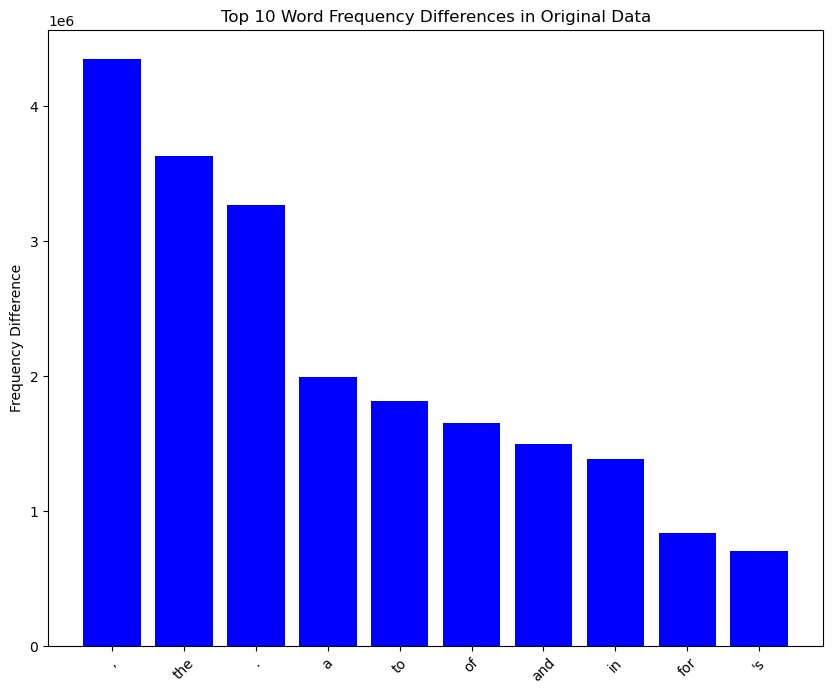

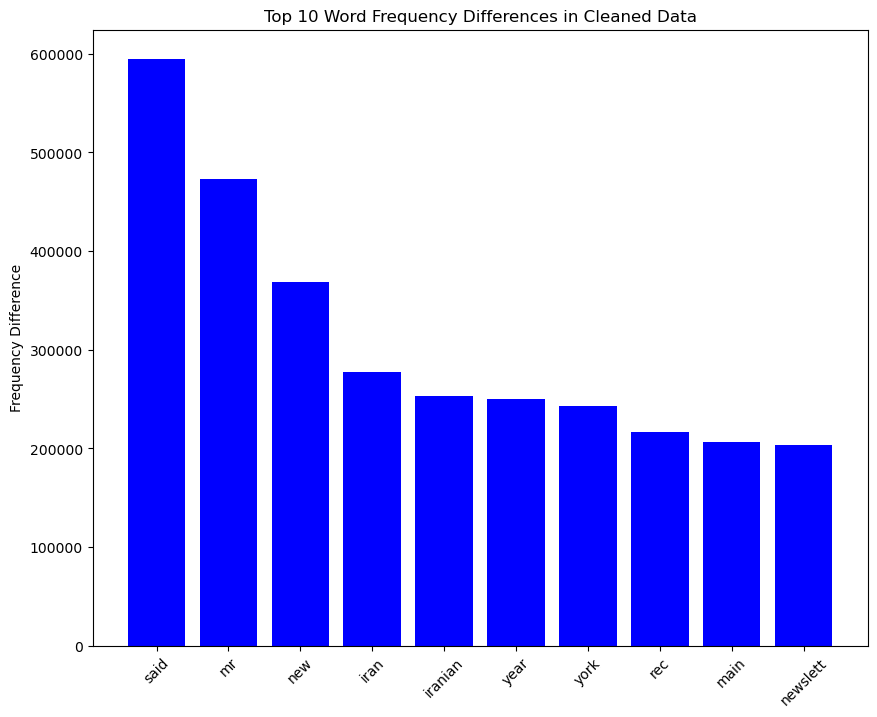

In [123]:
def get_word_frequencies(df):
    freqs_type_0 = Counter()
    freqs_type_1 = Counter()
    
    for _, row in df.iterrows():
        tokens = word_tokenize(row['content'].lower())
        if row['type'] == 0:
            freqs_type_0.update(tokens)
        else:
            freqs_type_1.update(tokens)
    
    return freqs_type_0, freqs_type_1

def plot_differences(freqs_type_0, freqs_type_1, title):
    diffs = {word: abs(freqs_type_0.get(word, 0) - freqs_type_1.get(word, 0)) 
             for word in set(freqs_type_0).union(set(freqs_type_1))}
    diffs = sorted(diffs.items(), key=lambda x: x[1], reverse=True)[:10]
    
    words, values = zip(*diffs)
    
    plt.figure(figsize=(10, 8))
    plt.bar(words, values, color='blue')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylabel('Frequency Difference')
    plt.show()
    
freqs_type_0_original, freqs_type_1_original = get_word_frequencies(df_original_processed)
freqs_type_0_cleaned, freqs_type_1_cleaned = get_word_frequencies(df_cleaned_processed)

plot_differences(freqs_type_0_original, freqs_type_1_original, 'Top 10 Word Frequency Differences in Original Data')
plot_differences(freqs_type_0_cleaned, freqs_type_1_cleaned, 'Top 10 Word Frequency Differences in Cleaned Data')

### Observation 6 - Top 10000 most frequent words

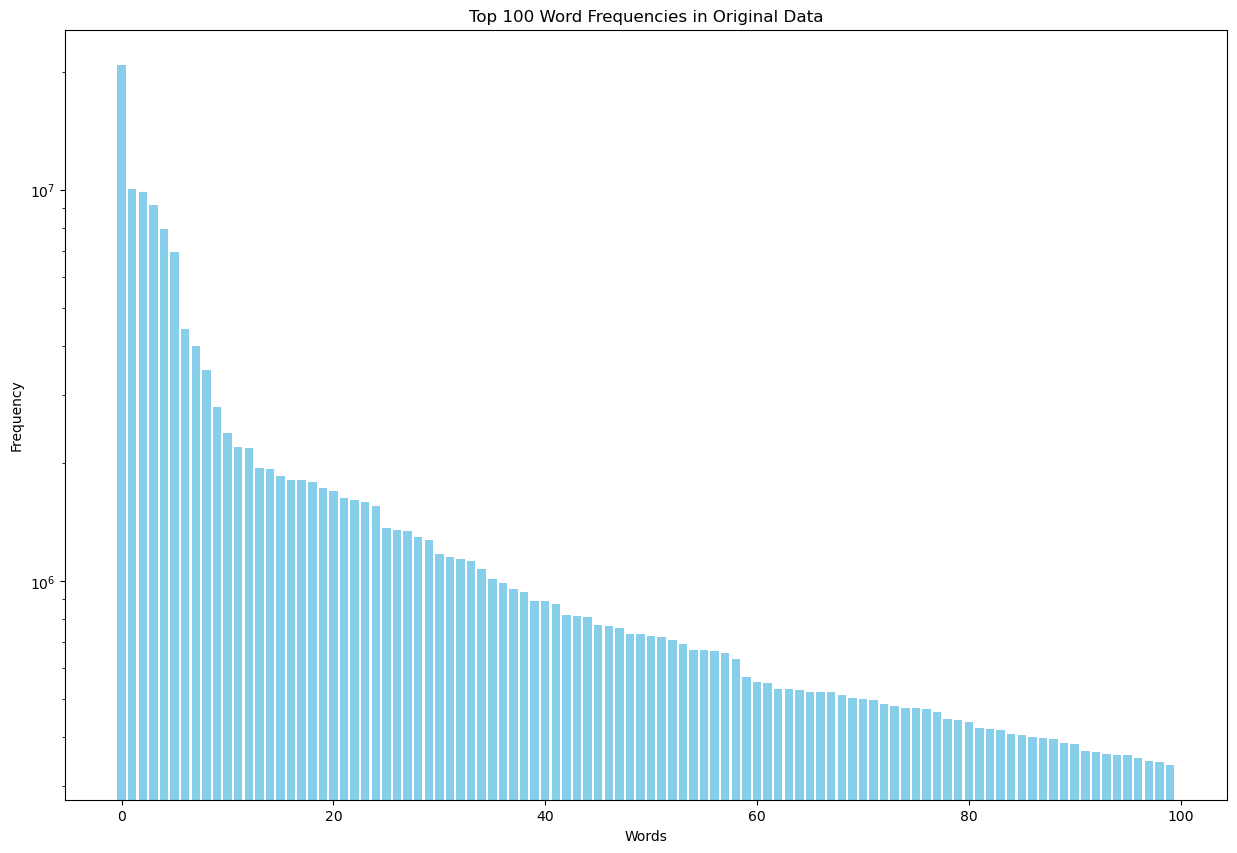

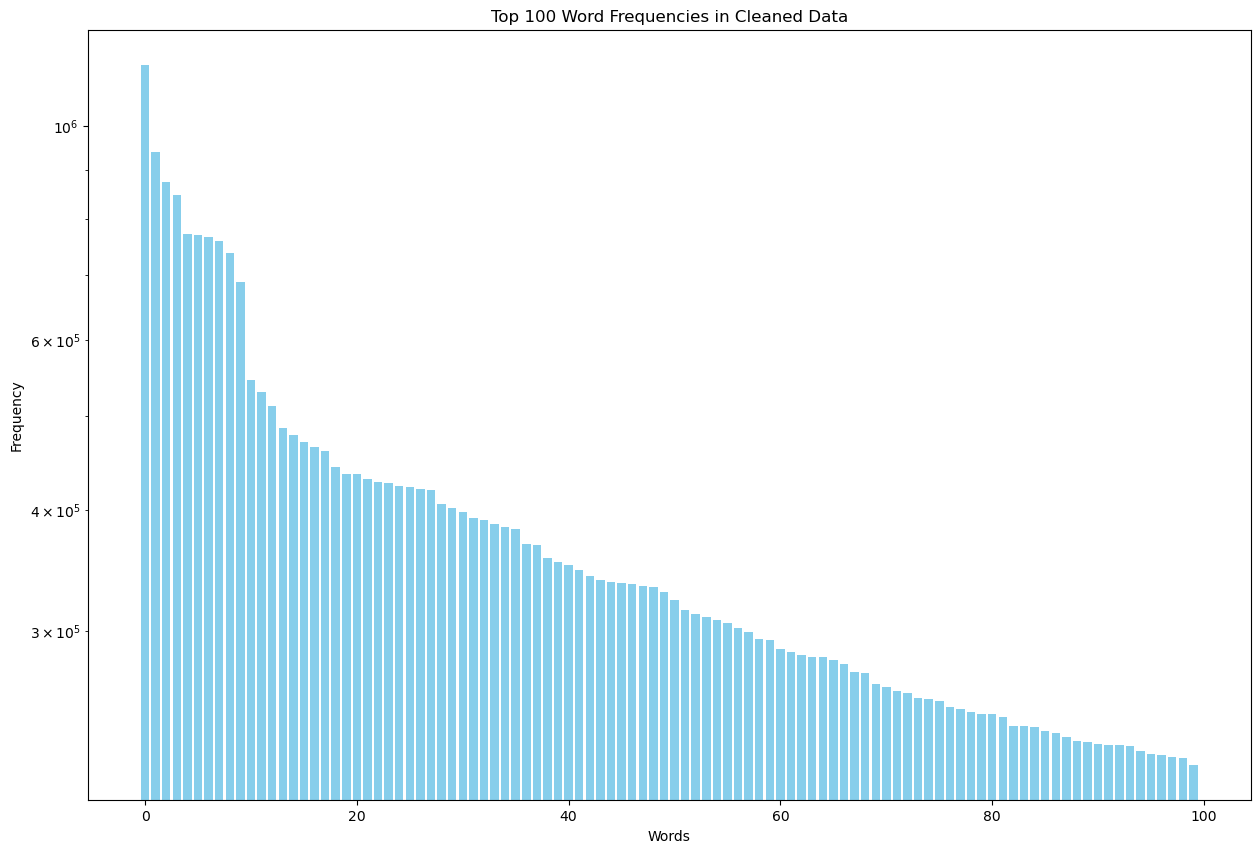

[('the', 20911794), ('of', 10033705), ('to', 9874589), ('and', 9137069), ('a', 7933398), ('in', 6939278), ('that', 4400707), ('is', 3982895), ('for', 3459601), ('on', 2781831), ('it', 2386132), ('as', 2201897), ('with', 2192123), ('was', 1946452), ('are', 1937170), ('by', 1852862), ('this', 1819389), ('i', 1812661), ('not', 1788840), ('at', 1729855), ('be', 1705015), ('have', 1632551), ('he', 1615320), ('from', 1591247), ('you', 1558206), ('an', 1371844), ('has', 1348246), ('but', 1340276), ('his', 1299511), ('they', 1276093), ('we', 1173161), ('said', 1156616), ('or', 1140573), ('its', 1126040), ('who', 1076951), ('will', 1012770), ('their', 990326), ('all', 955323), ('more', 936773), ('one', 888128), ('about', 887843), ('new', 874570), ('which', 817737), ('were', 816192), ('up', 808452), ('if', 774233), ('would', 767753), ('us', 758960), ('can', 733985), ('had', 733681), ('what', 722577), ('been', 721621), ('people', 707622), ('so', 693081), ('when', 668466), ('our', 668286), ('out',

In [148]:
def count_words(df, processed=False):
    counter = Counter()
    for content in df['content']:
        if processed:  
            words = content.split()
        else:  
            words = process_text_pipeline_simple(content)
        counter.update(words)
    return counter

def process_text_pipeline_simple(text):
    cleaned_text = clean_with_cleantext(text)
    tokens = tokenize(cleaned_text)
    return tokens

counter_original = count_words(df_original_processed, processed=False)
counter_cleaned = count_words(df_cleaned_processed, processed=True)

most_common_original = counter_original.most_common(10000)
most_common_cleaned = counter_cleaned.most_common(10000)

def plot_word_frequencies(word_freqs, title):
    words, frequencies = zip(*word_freqs)
    indices = np.arange(len(words))
    
    plt.figure(figsize=(15, 10))
    plt.bar(indices, frequencies, color='skyblue')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.yscale('log')
    plt.show()

plot_word_frequencies(most_common_original[:100], 'Top 100 Word Frequencies in Original Data')
plot_word_frequencies(most_common_cleaned[:100], 'Top 100 Word Frequencies in Cleaned Data')
print(most_common_original[:100])
print(most_common_cleaned[:100])

In [128]:
print(most_common_original[:100])

[('the', 20911794), ('of', 10033705), ('to', 9874589), ('and', 9137069), ('a', 7933398), ('in', 6939278), ('that', 4400707), ('is', 3982895), ('for', 3459601), ('on', 2781831), ('it', 2386132), ('as', 2201897), ('with', 2192123), ('was', 1946452), ('are', 1937170), ('by', 1852862), ('this', 1819389), ('i', 1812661), ('not', 1788840), ('at', 1729855), ('be', 1705015), ('have', 1632551), ('he', 1615320), ('from', 1591247), ('you', 1558206), ('an', 1371844), ('has', 1348246), ('but', 1340276), ('his', 1299511), ('they', 1276093), ('we', 1173161), ('said', 1156616), ('or', 1140573), ('its', 1126040), ('who', 1076951), ('will', 1012770), ('their', 990326), ('all', 955323), ('more', 936773), ('one', 888128), ('about', 887843), ('new', 874570), ('which', 817737), ('were', 816192), ('up', 808452), ('if', 774233), ('would', 767753), ('us', 758960), ('can', 733985), ('had', 733681), ('what', 722577), ('been', 721621), ('people', 707622), ('so', 693081), ('when', 668466), ('our', 668286), ('out',

In [127]:
print(most_common_cleaned[:100])

[('said', 1156674), ('one', 938376), ('new', 874720), ('year', 847801), ('state', 771893), ('time', 770939), ('would', 767756), ('us', 758960), ('peopl', 737364), ('like', 689466), ('mr', 545695), ('also', 530432), ('use', 512422), ('make', 486826), ('say', 477696), ('even', 470248), ('get', 464977), ('go', 460853), ('american', 443056), ('work', 435963), ('two', 435603), ('govern', 430557), ('day', 427469), ('right', 426995), ('presid', 423009), ('news', 422504), ('stori', 420146), ('first', 419885), ('nation', 406000), ('report', 402128), ('mani', 397628), ('read', 392538), ('continu', 390480), ('trump', 386921), ('could', 384175), ('come', 382376), ('world', 368953), ('iran', 367675), ('take', 356780), ('call', 353180), ('last', 350905), ('may', 346563), ('think', 341725), ('well', 338155), ('way', 337112), ('includ', 335881), ('back', 334918), ('know', 333447), ('want', 332995), ('see', 329162), ('york', 322623), ('polit', 315374), ('public', 312190), ('need', 309615), ('countri', 

### Observation 7 - Average Word in Title length

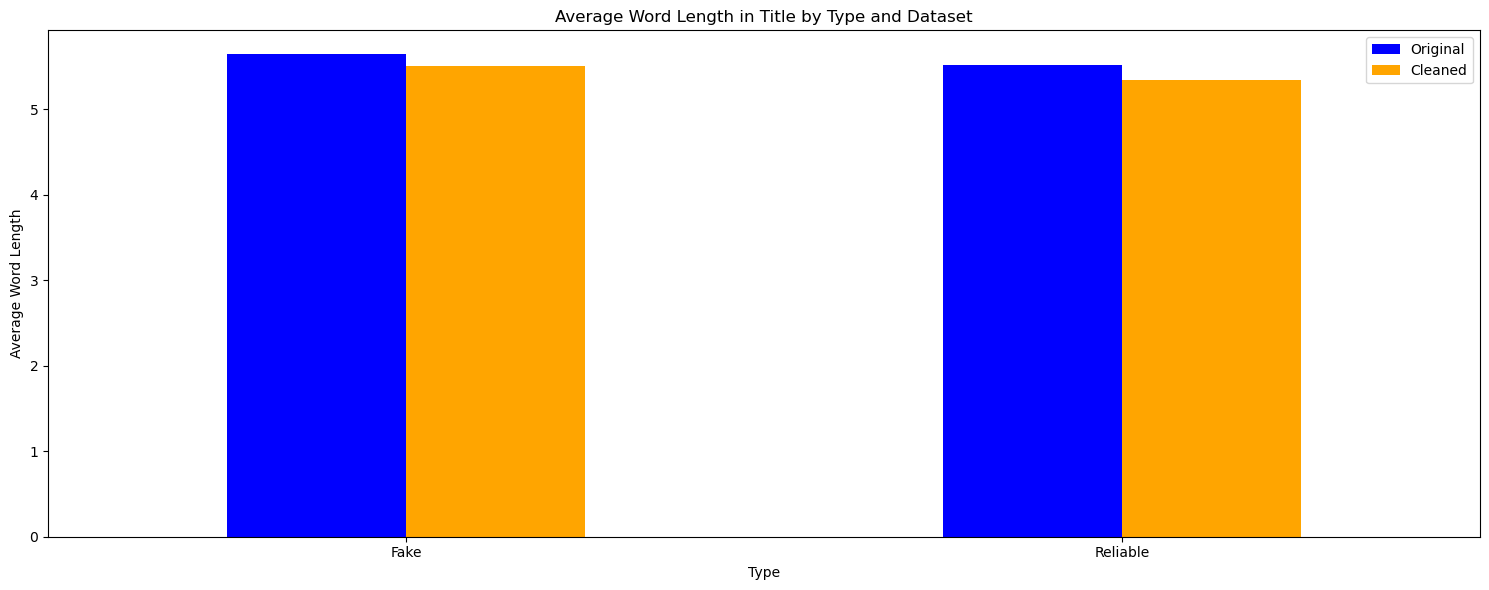

In [144]:
df_cleaned_processed['title'] = df_cleaned_processed['title'].apply(lambda x: ' '.join(process_text_pipeline(x)) if isinstance(x, str) else x)
def calculate_avg_word_length_by_type(df):
    df['average_word_length'] = df['title'].apply(lambda x: np.mean([len(word) for word in str(x).split()]) if len(str(x).split()) > 0 else 0)
    
    avg_word_length_by_type = df.groupby('type')['average_word_length'].mean()
    
    avg_word_length_by_type.index = avg_word_length_by_type.index.map({0: 'Fake', 1: 'Reliable'})
    
    return avg_word_length_by_type

def plot_avg_word_length(avg_word_length_original, avg_word_length_cleaned):
    df_plot = pd.DataFrame({'Original': avg_word_length_original, 'Cleaned': avg_word_length_cleaned})
    
    ax = df_plot.plot(kind='bar', figsize=(15, 6), color=['blue', 'orange'])
    plt.title('Average Word Length in Title by Type and Dataset')
    plt.xlabel('Type')
    plt.ylabel('Average Word Length')
    plt.xticks(rotation=0)
    plt.legend()
    plt.tight_layout()
    plt.show()
avg_word_length_original = calculate_avg_word_length_by_type(df_original_processed)
avg_word_length_cleaned = calculate_avg_word_length_by_type(df_cleaned_processed)

plot_avg_word_length(avg_word_length_original, avg_word_length_cleaned)

### Observation 8 - Average Title length

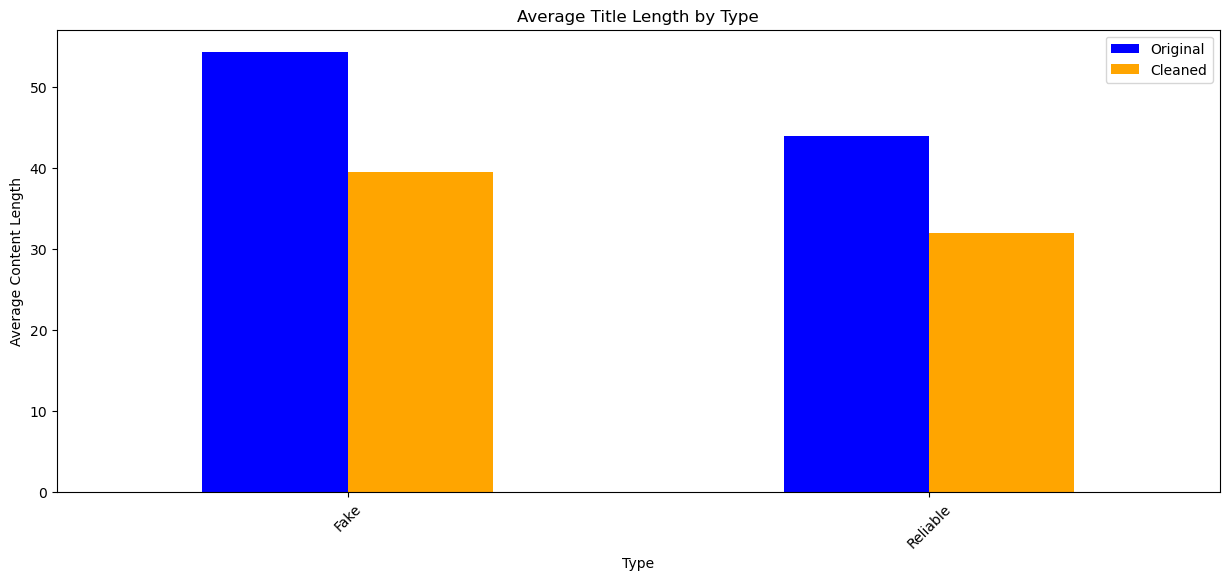

In [145]:
def calculate_avg_content_length_by_type(df):
    df['content_length'] = df['title'].apply(lambda x: len(str(x)))
    
    avg_content_length_by_type = df.groupby('type')['content_length'].mean()
    
    avg_content_length_by_type.index = avg_content_length_by_type.index.map({0: 'Fake', 1: 'Reliable'})
    
    return avg_content_length_by_type

def plot_avg_content_length(avg_content_length_original, avg_content_length_cleaned):
    df_plot = pd.DataFrame({'Original': avg_content_length_original, 'Cleaned': avg_content_length_cleaned})
    
    ax = df_plot.plot(kind='bar', figsize=(15, 6), color=['blue', 'orange'])
    plt.title('Average Title Length by Type')
    plt.xlabel('Type')
    plt.ylabel('Average Content Length')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

avg_content_length_original = calculate_avg_content_length_by_type(df_original_processed)
avg_content_length_cleaned = calculate_avg_content_length_by_type(df_cleaned_processed)

plot_avg_content_length(avg_content_length_original, avg_content_length_cleaned)

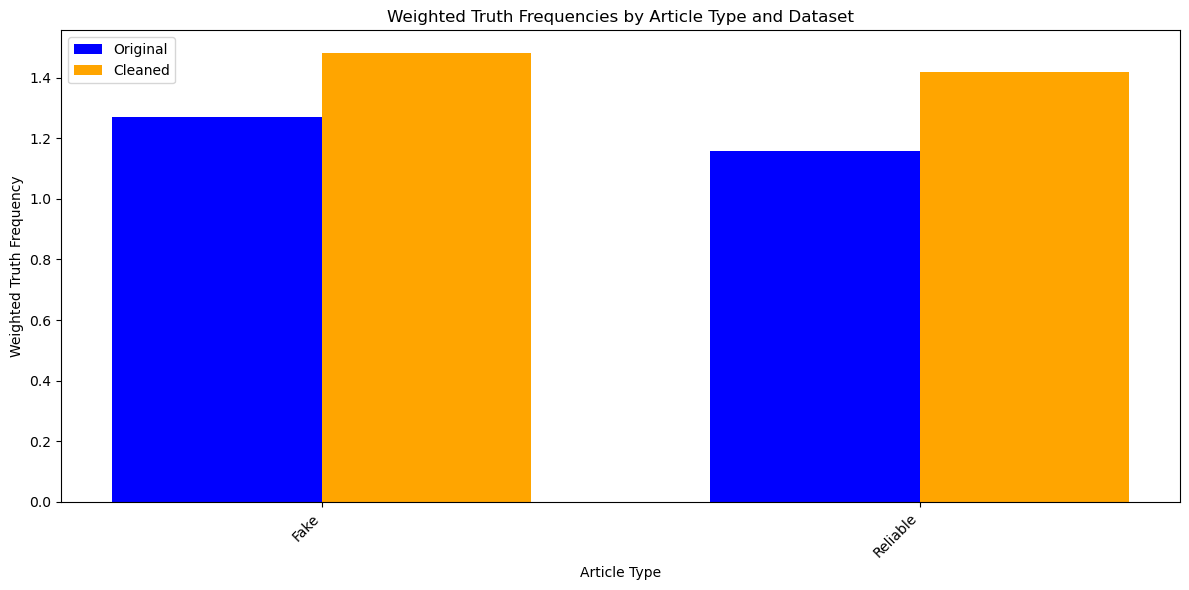

In [147]:
def calculate_weighted_truth_frequencies(df):
    truth_frequencies = {}
    article_counts = {}
    words = ['truth', 'true', 'truly', 'truthful', 'truthfulness', 'science', 'scientifically', 'proven', 'shown', 'know', 'scienc', 'science', 'scientif', 'scientific', 'prov', 'show', 'fact', 'factually']
    pattern = re.compile(r'\b(' + '|'.join(words) + r')\b', re.IGNORECASE)
    
    for _, row in df.iterrows():
        arttype = row['type']
        content = str(row['content'])
        word_count = len(pattern.findall(content))
        
        if arttype in truth_frequencies:
            truth_frequencies[arttype] += word_count
            article_counts[arttype] += 1
        else:
            truth_frequencies[arttype] = word_count
            article_counts[arttype] = 1
    
    weighted_truth_frequencies = {arttype: truth_frequencies[arttype] / article_counts[arttype] for arttype in truth_frequencies}
    return weighted_truth_frequencies

categories = ['Fake', 'Reliable']
category_map = {0: 'Fake', 1: 'Reliable'}

original_freqs = [weighted_truth_freq_original.get(num, 0) for num in [0, 1]]
cleaned_freqs = [weighted_truth_freq_cleaned.get(num, 0) for num in [0, 1]]

x = range(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x, original_freqs, width, label='Original', color='blue')
bars2 = ax.bar([p + width for p in x], cleaned_freqs, width, label='Cleaned', color='orange')

ax.set_xlabel('Article Type')
ax.set_ylabel('Weighted Truth Frequency')
ax.set_title('Weighted Truth Frequencies by Article Type and Dataset')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(categories)
ax.legend()

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
